In [ ]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os
from sklearn.datasets import load_iris
from linearmodels.iv import IV2SLS
from statsmodels.formula.api import quantreg, wls
from statsmodels.iolib.summary2 import summary_col
from PIL import Image
from statsmodels.stats.stattools import durbin_watson
from collections import OrderedDict
from linearmodels.iv.results import compare
import doubleml as dml
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import clone
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from doubleml import DoubleMLData, DoubleMLPLIV
from doubleml.utils import DMLDummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import holidays
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from sklearn.inspection import permutation_importance


import doubleml as dml
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-26tbf2cv because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# Data cleaning and merging
## 1) Clean original dataset + create dummies
## 2) Merge Gas Prices
## 3) Merge Coal and Emission
## 4) Fill Wind_Offshore with 0

In [ ]:
def process_generation_data(data_path, cutoff_date):
    """
    Process the generation data by pivoting, converting time to datetime, converting temperature to Fahrenheit,
    converting prices to cents EUR/kWh, filtering based on a cutoff date, and adding temperature bins and block variables.

    Parameters:
    - data_path: str, path to the CSV file containing the data.
    - cutoff_date: str, cutoff date in the format 'YYYY-MM-DD'. Rows after this date will be filtered out.

    Returns:
    - pd.DataFrame: The filtered and processed DataFrame.
    """
    # Read the CSV data into a pandas DataFrame
    data = pd.read_csv(data_path)

    # Pivot the DataFrame to make GenerationPsrType as columns
    generation_pivot = data.pivot_table(
        index=['Time', 'PriceArea', 'ConsumptionValue', 'DayAheadPriceEUR', 'WeatherWindSpeed', 'WeatherTemperature'],
        columns='GenerationPsrType',
        values='GenerationValue'
    )

    # Flatten the columns to make them part of the DataFrame
    generation_pivot.columns = generation_pivot.columns.get_level_values(0)  # Flatten MultiIndex if exists

    # Reset index to turn multi-index into columns
    generation_pivot = generation_pivot.reset_index()

    # Rename columns for better readability (if necessary)
    generation_pivot.columns.name = None
    generation_pivot = generation_pivot.rename_axis(None, axis=1)

    # Convert the Time column to datetime format
    generation_pivot['Time'] = pd.to_datetime(generation_pivot['Time'])
    generation_pivot['Year'] = generation_pivot['Time'].dt.year
    generation_pivot['Month'] = generation_pivot['Time'].dt.month
    generation_pivot['Day'] = generation_pivot['Time'].dt.day
    generation_pivot['Hour'] = generation_pivot['Time'].dt.hour

    # Convert WeatherTemperature from Kelvin to Fahrenheit
    generation_pivot['WeatherTemperature_F'] = (generation_pivot['WeatherTemperature'] - 273.15) * 9 / 5 + 32


    # Define the GBP to EUR exchange rates by year
    gbp_to_eur_rates = {
        2024: 1.185803, 2023: 1.160690, 2022: 1.183502, 2021: 1.167107, 2020: 1.189218,
        2019: 1.180270, 2018: 1.113941, 2017: 1.128496, 2016: 1.189051, 2015: 1.386397
    }

    # Define UAH to EUR exchange rates by year
    uah_to_eur_rates = {
        2024: 0.022481, 2023: 0.025357, 2022: 0.031368, 2021: 0.031804, 2020: 0.037345,
        2019: 0.036763, 2018: 0.031643, 2017: 0.033471, 2016: 0.036130, 2015: 0.039340
    }
    # Define BGN to EUR exchange rates by month for the period 1.11.2016 to 21.01.2022
    bgn_to_eur_rates = {
        '2016-10': 0.511292, '2016-11': 0.511292, '2016-12': 0.511292, '2017-01': 0.511292, '2017-02': 0.511292, '2017-03': 0.511292,
        '2017-04': 0.511292, '2017-05': 0.511292, '2017-06': 0.511292, '2017-07': 0.511292, '2017-08': 0.511292,
        '2017-09': 0.511292, '2017-10': 0.511292, '2017-11': 0.511292, '2017-12': 0.511292, '2018-01': 0.511292,
        '2018-02': 0.511292, '2018-03': 0.511292, '2018-04': 0.511292, '2018-05': 0.511292, '2018-06': 0.511292,
        '2018-07': 0.511292, '2018-08': 0.511292, '2018-09': 0.511292, '2018-10': 0.511292, '2018-11': 0.511292,
        '2018-12': 0.511292, '2019-01': 0.511292, '2019-02': 0.511292, '2019-03': 0.511292, '2019-04': 0.511292,
        '2019-05': 0.511292, '2019-06': 0.511292, '2019-07': 0.511292, '2019-08': 0.511292, '2019-09': 0.511292,
        '2019-10': 0.511292, '2019-11': 0.511292, '2019-12': 0.511292, '2020-01': 0.511292, '2020-02': 0.511292,
        '2020-03': 0.511292, '2020-04': 0.511292, '2020-05': 0.511292, '2020-06': 0.511292, '2020-07': 0.511292,
        '2020-08': 0.511292, '2020-09': 0.511292, '2020-10': 0.511292, '2020-11': 0.511292, '2020-12': 0.511292,
        '2021-01': 0.511292, '2021-02': 0.511292, '2021-03': 0.511292, '2021-04': 0.511292, '2021-05': 0.511292,
        '2021-06': 0.511292, '2021-07': 0.511292, '2021-08': 0.511292, '2021-09': 0.511292, '2021-10': 0.511292,
        '2021-11': 0.511292, '2021-12': 0.511292, '2022-01': 0.511292
    }

    pln_to_eur_rates = {
        '2017-03': 0.233271, '2017-04': 0.235994, '2017-05': 0.238112, '2017-06': 0.237464, '2017-07': 0.236062,
        '2017-08': 0.234339, '2017-09': 0.234235, '2017-10': 0.234603, '2017-11': 0.236591, '2017-12': 0.237914,
        '2018-01': 0.240200, '2018-02': 0.240079, '2018-03': 0.237577, '2018-04': 0.238461, '2018-05': 0.233377,
        '2018-06': 0.232367, '2018-07': 0.231285, '2018-08': 0.233335, '2018-09': 0.232527, '2018-10': 0.232312,
        '2018-11': 0.232465, '2018-12': 0.233101, '2019-01': 0.233014, '2019-02': 0.231620, '2019-03': 0.232728,
        '2019-04': 0.233296, '2019-05': 0.232789, '2019-06': 0.234550, '2019-07': 0.234767, '2019-08': 0.230072,
        '2019-09': 0.229726, '2019-10': 0.232502, '2019-11': 0.233351
    }

    ron_to_eur_rates = {
        '2015-01': 0.222850, '2015-02': 0.225562, '2015-03': 0.225538, '2015-04': 0.226476, '2015-05': 0.224836,
        '2015-06': 0.223860, '2015-07': 0.225279, '2015-08': 0.226068, '2015-09': 0.226062, '2015-10': 0.226106,
        '2015-11': 0.224960, '2015-12': 0.222064, '2016-01': 0.220699, '2016-02': 0.223151, '2016-03': 0.223884,
        '2016-04': 0.223593, '2016-05': 0.222270, '2016-06': 0.221092, '2016-07': 0.222943, '2016-08': 0.224259,
        '2016-09': 0.224707, '2016-10': 0.222513, '2016-11': 0.221728, '2016-12': 0.221419, '2017-01': 0.222134,
        '2017-02': 0.221554, '2017-03': 0.219895, '2017-04': 0.220795, '2017-05': 0.219591, '2017-06': 0.218721,
        '2017-07': 0.218873, '2017-08': 0.218400, '2017-09': 0.217430, '2017-10': 0.217889, '2017-11': 0.215769,
        '2017-12': 0.215761, '2018-01': 0.215097, '2018-02': 0.214781, '2018-03': 0.214531, '2018-04': 0.214693,
        '2018-05': 0.215500, '2018-06': 0.214487, '2018-07': 0.215036, '2018-08': 0.215340, '2018-09': 0.215188,
        '2018-10': 0.214326, '2018-11': 0.214547, '2018-12': 0.214889, '2019-01': 0.212501, '2019-02': 0.210590,
        '2019-03': 0.210323, '2019-04': 0.210157, '2019-05': 0.210113, '2019-06': 0.211640, '2019-07': 0.211479,
        '2019-08': 0.211506, '2019-09': 0.211057, '2019-10': 0.210357, '2019-11': 0.209652, '2019-12': 0.209297,
        '2020-01': 0.209258, '2020-02': 0.209045, '2020-03': 0.207120, '2020-04': 0.206734, '2020-05': 0.206735,
        '2020-06': 0.206648, '2020-07': 0.206683, '2020-08': 0.206714, '2020-09': 0.205753, '2020-10': 0.205139,
        '2020-11': 0.205324, '2020-12': 0.205328, '2021-01': 0.205202, '2021-02': 0.205129, '2021-03': 0.204569,
        '2021-04': 0.203123, '2021-05': 0.203046, '2021-06': 0.203095, '2021-07': 0.203025, '2021-08': 0.203122,
        '2021-09': 0.202138, '2021-10': 0.202100, '2021-11': 0.202046, '2021-12': 0.202053, '2022-01': 0.202208,
        '2022-02': 0.202193, '2022-03': 0.202092, '2022-04': 0.202259, '2022-05': 0.202184, '2022-06': 0.202249,
        '2022-07': 0.202446, '2022-08': 0.204323, '2022-09': 0.203695, '2022-10': 0.203010, '2022-11': 0.203494,
        '2022-12': 0.203153, '2023-01': 0.203079, '2023-02': 0.203722, '2023-03': 0.202992, '2023-04': 0.202571,
        '2023-05': 0.202147, '2023-06': 0.201614, '2023-07': 0.202385, '2023-08': 0.202385, '2023-09': 0.201386,
        '2023-10': 0.201281, '2023-11': 0.201197, '2023-12': 0.201178, '2024-01': 0.201007, '2024-02': 0.201020,
        '2024-03': 0.201171, '2024-04': 0.201084, '2024-05': 0.200989, '2024-06': 0.200935, '2024-07': 0.201086
    }

    # Function to apply currency conversion based on PriceArea and Year/Month and cutoff date
    def convert_currency_to_eur(row):
        year_month = f"{row['Year']}-{str(row['Month']).zfill(2)}"
        start_date = pd.Timestamp("2016-10-31")
        cutoff_date_1 = pd.Timestamp("2022-01-21 22:00:00")
        pln_start_date = pd.Timestamp("2017-03-01 23:00:00")
        pln_end_date = pd.Timestamp("2019-11-19 22:00:00")
        rol_start_date = pd.Timestamp("2015-01-01")
        rol_end_date = pd.Timestamp("2021-06-17 21:00:00")
        if row['PriceArea'] == 'RO' and (rol_start_date <= row['Time'] <= rol_end_date):
            exchange_rate = ron_to_eur_rates.get(year_month, 1)  # Get ROL to EUR rate for the period
            return row['DayAheadPriceEUR'] * exchange_rate
        if row['PriceArea'] == 'BG' and (start_date <= row['Time'] <= cutoff_date_1):
            exchange_rate = bgn_to_eur_rates.get(year_month, 1)  # Get BGN to EUR rate for the period
            return row['DayAheadPriceEUR'] * exchange_rate
        if row['PriceArea'] == 'PL' and (pln_start_date <= row['Time'] <= pln_end_date):
            exchange_rate = pln_to_eur_rates.get(year_month, 1)
            return row['DayAheadPriceEUR'] * exchange_rate
        elif row['PriceArea'] == 'GB':
            exchange_rate = gbp_to_eur_rates.get(row['Year'], 1)  # Get GBP to EUR rate
            return row['DayAheadPriceEUR'] * exchange_rate
        elif row['PriceArea'] in ['UA_BEI', 'UA_IPS']:
            exchange_rate = uah_to_eur_rates.get(row['Year'], 1)  # Get UAH to EUR rate
            return row['DayAheadPriceEUR'] * exchange_rate
        return row['DayAheadPriceEUR']  # No conversion for other PriceAreas or outside the specified BGN date range


    # Apply the conversion to the 'DayAheadPrice' column
    generation_pivot['DayAheadPriceEUR'] = generation_pivot.apply(convert_currency_to_eur, axis=1)

    # ConsumptionValue is MW
    # Solar is MW
    generation_pivot['Solar_MWh'] = generation_pivot['B16']
    # Wind_Offshore is MW
    generation_pivot['Wind_Offshore'] = generation_pivot['B18']
    # Wind_Onshore is MW
    generation_pivot['Wind_Onshore'] = generation_pivot['B19']

    # Define the cutoff date and filter the DataFrame to keep only rows where Time is on or before the cutoff date
    cutoff_date = pd.Timestamp(cutoff_date)
    filtered_data = generation_pivot[generation_pivot['Time'] <= cutoff_date].copy()  # Use .copy() to avoid warnings

    # Replace 0 hour with 24
    filtered_data.loc[:, 'Hour'] = filtered_data['Hour'].replace(0, 24)

    # Create a year-month column
    filtered_data.loc[:, 'ym'] = filtered_data['Year'].astype(str) + '-' + filtered_data['Month'].astype(str).str.zfill(2)

    # Create temperature bins
    conditions_tempbin = [
        (filtered_data['WeatherTemperature_F'] < 30),
        (filtered_data['WeatherTemperature_F'] >= 30) & (filtered_data['WeatherTemperature_F'] < 40),
        (filtered_data['WeatherTemperature_F'] >= 40) & (filtered_data['WeatherTemperature_F'] < 50),
        (filtered_data['WeatherTemperature_F'] >= 50) & (filtered_data['WeatherTemperature_F'] < 60),
        (filtered_data['WeatherTemperature_F'] >= 60) & (filtered_data['WeatherTemperature_F'] < 70),
        (filtered_data['WeatherTemperature_F'] >= 70) & (filtered_data['WeatherTemperature_F'] < 80),
        (filtered_data['WeatherTemperature_F'] >= 80) & (filtered_data['WeatherTemperature_F'] < 90),
        (filtered_data['WeatherTemperature_F'] >= 90)
    ]
    choices_tempbin = [1, 2, 3, 4, 5, 6, 7, 8]
    filtered_data.loc[:, 'tempbin'] = np.select(conditions_tempbin, choices_tempbin, default=np.nan)
    filtered_data.loc[:, 'tempbin2'] = filtered_data['WeatherTemperature_F'] ** 2 / 1000.0

    # Create block variable based on the hour of the day
    conditions_block = [
        (filtered_data['Hour'] >= 1) & (filtered_data['Hour'] <= 4),
        (filtered_data['Hour'] >= 5) & (filtered_data['Hour'] <= 8),
        (filtered_data['Hour'] >= 9) & (filtered_data['Hour'] <= 12),
        (filtered_data['Hour'] >= 13) & (filtered_data['Hour'] <= 16),
        (filtered_data['Hour'] >= 17) & (filtered_data['Hour'] <= 20),
        (filtered_data['Hour'] >= 21) & (filtered_data['Hour'] <= 24)
    ]
    choices_block = [1, 2, 3, 4, 5, 6]
    filtered_data.loc[:, 'block'] = np.select(conditions_block, choices_block, default=np.nan)
    filtered_data['YearMonthDay'] = filtered_data['Time'].dt.strftime('%Y-%m-%d')

    # Return the filtered data
    return filtered_data

# Usage example
filtered_data = process_generation_data("combined_data.csv", "2024-07-01")
filtered_data

,Time,PriceArea,ConsumptionValue,DayAheadPriceEUR,WeatherWindSpeed,WeatherTemperature,B16,B18,B19,Year,...,Hour,WeatherTemperature_F,Solar_MWh,Wind_Offshore,Wind_Onshore,ym,tempbin,tempbin2,block,YearMonthDay
0,2015-01-01 01:00:00,CH,7654.0,38.08,3.647062,267.706482,0.0,NaN,14.0,2015,...,1,22.201667,0.0,NaN,14.0,2015-01,1.0,0.492914,1.0,2015-01-01
1,2015-01-01 01:00:00,CZ,5958.0,22.06,5.904290,270.820374,0.0,NaN,38.0,2015,...,1,27.806672,0.0,NaN,38.0,2015-01,1.0,0.773211,1.0,2015-01-01
2,2015-01-01 01:00:00,DK_1,1795.0,16.04,10.881969,278.429504,0.0,567.0,1207.0,2015,...,1,41.503108,0.0,567.0,1207.0,2015-01,3.0,1.722508,1.0,2015-01-01
3,2015-01-01 01:00:00,DK_2,1305.0,16.04,10.561893,276.635590,0.0,336.0,248.0,2015,...,1,38.274061,0.0,336.0,248.0,2015-01,2.0,1.464904,1.0,2015-01-01
4,2015-01-01 01:00:00,EE,765.0,19.33,7.610929,274.071991,0.0,NaN,46.0,2015,...,1,33.659584,0.0,NaN,46.0,2015-01,2.0,1.132968,1.0,2015-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3197089,2024-07-01 00:00:00,SE_2,1276.0,28.85,3.691103,284.465790,0.0,NaN,412.0,2024,...,24,52.368422,0.0,NaN,412.0,2024-07,4.0,2.742452,6.0,2024-07-01
3197090,2024-07-01 00:00:00,SE_3,6609.0,28.85,5.252436,285.699829,0.0,NaN,558.0,2024,...,24,54.589692,0.0,NaN,558.0,2024-07,4.0,2.980035,6.0,2024-07-01
3197091,2024-07-01 00:00:00,SE_4,1695.0,76.31,6.840746,286.239319,1.0,NaN,612.0,2024,...,24,55.560774,1.0,NaN,612.0,2024-07,4.0,3.087000,6.0,2024-07-01
3197092,2024-07-01 00:00:00,SI,1079.0,75.88,3.590000,294.160553,0.0,NaN,0.0,2024,...,24,69.818995,0.0,NaN,0.0,2024-07,5.0,4.874692,6.0,2024-07-01


In [ ]:
filtered_data = pd.read_csv("filtered_data_all_final.csv", index_col=0)
filtered_data['Time'] = pd.to_datetime(filtered_data['Time'], errors='coerce')
filtered_data['YearMonthDay'] = pd.to_datetime(filtered_data['YearMonthDay'], errors='coerce')
filtered_data

,Unnamed: 0,Time,PriceArea,ConsumptionValue,DayAheadPriceEUR,WeatherWindSpeed,WeatherTemperature,Year,Month,Day,Hour,WeatherTemperature_F,Solar_MWh,Wind_Offshore,Wind_Onshore,ym,tempbin,tempbin2,block,YearMonthDay
0,0.0,2015-01-01 01:00:00,CH,7654.0,38.08,3.647062,267.706482,2015.0,1.0,1.0,1.0,22.201667,0.0,NaN,14.0,2015-01,1.0,0.492914,1.0,2015-01-01
1,NaN,2015-01-01 01:00:00,DE_LU,44237.0,NaN,4.465744,272.602615,2015.0,1.0,1.0,1.0,31.014708,0.0,520.75,9060.5,2015-01,2.0,0.961912,1.0,2015-01-01
2,19.0,2015-01-01 01:00:00,LV,645.0,29.56,7.677394,273.660492,2015.0,1.0,1.0,1.0,32.918885,NaN,NaN,13.0,2015-01,2.0,1.083653,1.0,2015-01-01
3,17.0,2015-01-01 01:00:00,SK,2728.0,22.06,3.991796,265.239655,2015.0,1.0,1.0,1.0,17.761378,4.0,NaN,0.0,2015-01,1.0,0.315467,1.0,2015-01-01
4,16.0,2015-01-01 01:00:00,SI,1045.0,22.20,4.172168,265.189819,2015.0,1.0,1.0,1.0,17.671675,0.0,NaN,1.0,2015-01,1.0,0.312288,1.0,2015-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3262792,3242772.0,2024-07-01 00:00:00,ME,258.0,87.35,3.525761,295.488159,2024.0,7.0,1.0,24.0,72.208687,NaN,NaN,10.0,2024-07,6.0,5.214094,6.0,2024-07-01
3262793,3242773.0,2024-07-01 00:00:00,EE,560.0,81.35,9.700132,290.992065,2024.0,7.0,1.0,24.0,64.115718,0.0,NaN,227.0,2024-07,5.0,4.110825,6.0,2024-07-01
3262794,3242774.0,2024-07-01 00:00:00,NL,9551.0,78.19,6.221703,287.067200,2024.0,7.0,1.0,24.0,57.050959,1.0,1092.00,564.0,2024-07,4.0,3.254812,6.0,2024-07-01
3262795,3242750.0,2024-07-01 00:00:00,FR,34397.0,52.95,5.007311,288.667023,2024.0,7.0,1.0,24.0,59.930641,0.0,373.00,2290.0,2024-07,4.0,3.591682,6.0,2024-07-01


In [ ]:
m = filtered_data[filtered_data['PriceArea'] == 'AT']
m = m[m['Year'] == 2016]
m

,Unnamed: 0,Time,PriceArea,ConsumptionValue,DayAheadPriceEUR,WeatherWindSpeed,WeatherTemperature,Year,Month,Day,Hour,WeatherTemperature_F,Solar_MWh,Wind_Offshore,Wind_Onshore,ym,tempbin,tempbin2,block,YearMonthDay
327189,322149.0,2016-01-01 00:00:00,AT,6512.0,19.50,2.730384,271.279175,2016.0,1.0,1.0,24.0,28.632515,0.0,NaN,229.25,2016-01,1.0,0.819821,6.0,2016-01-01
327225,322187.0,2016-01-01 01:00:00,AT,6179.0,18.50,2.672074,271.373413,2016.0,1.0,1.0,1.0,28.802144,0.0,NaN,152.50,2016-01,1.0,0.829563,1.0,2016-01-01
327243,322216.0,2016-01-01 02:00:00,AT,5933.0,17.47,2.653408,271.481781,2016.0,1.0,1.0,2.0,28.997206,0.0,NaN,109.50,2016-01,1.0,0.840838,1.0,2016-01-01
327283,322260.0,2016-01-01 03:00:00,AT,5727.0,14.49,2.635592,271.556244,2016.0,1.0,1.0,3.0,29.131239,0.0,NaN,55.50,2016-01,1.0,0.848629,1.0,2016-01-01
327315,322298.0,2016-01-01 04:00:00,AT,5407.0,12.97,2.634339,271.545685,2016.0,1.0,1.0,4.0,29.112233,0.0,NaN,39.00,2016-01,1.0,0.847522,1.0,2016-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
659234,648985.0,2016-12-31 19:00:00,AT,7942.0,39.19,3.578223,273.169312,2016.0,12.0,31.0,19.0,32.034761,0.0,NaN,112.75,2016-12,2.0,1.026226,5.0,2016-12-31
659279,649006.0,2016-12-31 20:00:00,AT,7436.0,35.88,3.559708,273.025665,2016.0,12.0,31.0,20.0,31.776198,0.0,NaN,119.75,2016-12,2.0,1.009727,5.0,2016-12-31
659322,649060.0,2016-12-31 21:00:00,AT,7031.0,34.17,3.494145,272.909576,2016.0,12.0,31.0,21.0,31.567238,0.0,NaN,118.00,2016-12,2.0,0.996490,6.0,2016-12-31
659357,649095.0,2016-12-31 22:00:00,AT,6710.0,35.28,3.483436,272.775024,2016.0,12.0,31.0,22.0,31.325044,0.0,NaN,113.75,2016-12,2.0,0.981258,6.0,2016-12-31


In [ ]:
filtered_data.columns

Index(['Time', 'PriceArea', 'ConsumptionValue', 'DayAheadPriceEUR',
       'WeatherWindSpeed', 'WeatherTemperature', 'Year', 'Month', 'Day',
       'Hour', 'WeatherTemperature_F', 'Solar_MWh', 'Wind_Offshore',
       'Wind_Onshore', 'ym', 'tempbin', 'tempbin2', 'block', 'YearMonthDay'],
      dtype='object')

In [ ]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3242785 entries, 0 to 3242784
Data columns (total 19 columns):
 #   Column                Dtype         
---  ------                -----         
 0   Time                  datetime64[ns]
 1   PriceArea             object        
 2   ConsumptionValue      float64       
 3   DayAheadPriceEUR      float64       
 4   WeatherWindSpeed      float64       
 5   WeatherTemperature    float64       
 6   Year                  float64       
 7   Month                 float64       
 8   Day                   float64       
 9   Hour                  float64       
 10  WeatherTemperature_F  float64       
 11  Solar_MWh             float64       
 12  Wind_Offshore         float64       
 13  Wind_Onshore          float64       
 14  ym                    object        
 15  tempbin               float64       
 16  tempbin2              float64       
 17  block                 float64       
 18  YearMonthDay          datetime64[ns]
dtypes: da

In [ ]:
filtered_at = filtered_data.loc[filtered_data ['PriceArea'] == 'AT', ['Time', 'ConsumptionValue']]
filtered_at

,Time,ConsumptionValue
40,2015-01-01 02:00:00,5964.0
51,2015-01-01 03:00:00,5726.0
77,2015-01-01 04:00:00,5347.0
101,2015-01-01 05:00:00,5249.0
115,2015-01-01 06:00:00,5308.0
...,...,...
3262613,2024-06-30 20:00:00,5937.0
3262653,2024-06-30 21:00:00,5560.0
3262711,2024-06-30 22:00:00,5368.0
3262739,2024-06-30 23:00:00,5062.0


In [ ]:
filled_data_gas = pd.read_csv('filled_data.csv')
filled_data_gas

,Trading_Day,Price_Area,Last_Price
0,2015-01-01,cegh,20.650
1,2015-01-02,cegh,20.700
2,2015-01-03,cegh,20.200
3,2015-01-04,cegh,22.000
4,2015-01-05,cegh,22.450
...,...,...,...
32197,2024-10-13,ztp,40.775
32198,2024-10-14,ztp,40.500
32199,2024-10-15,ztp,39.750
32200,2024-10-16,ztp,39.200


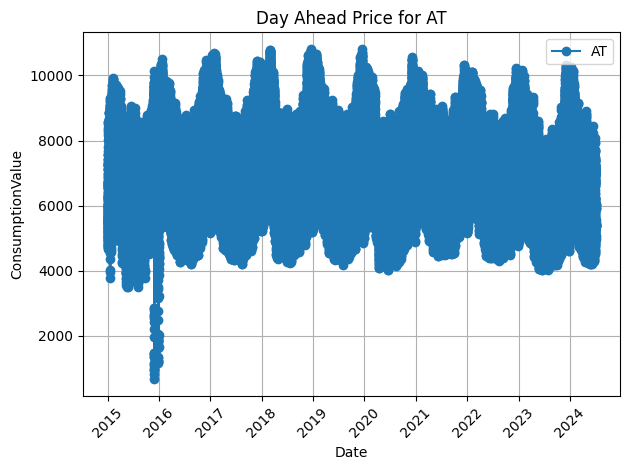

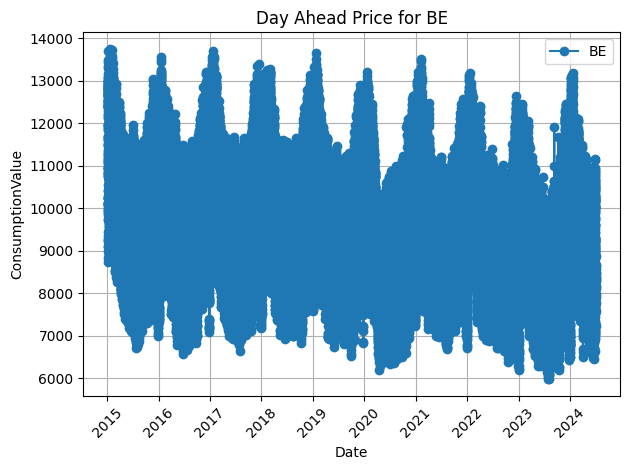

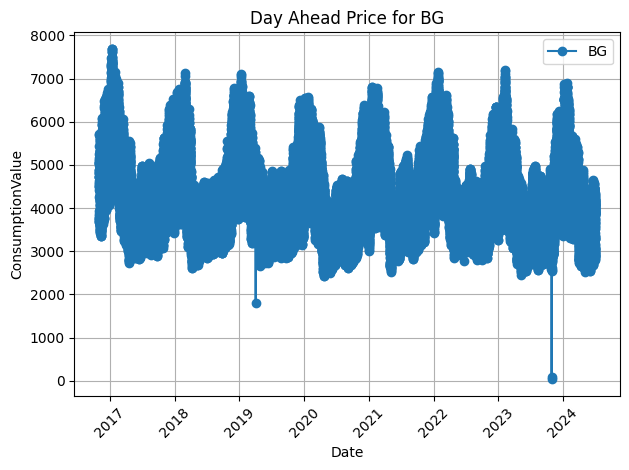

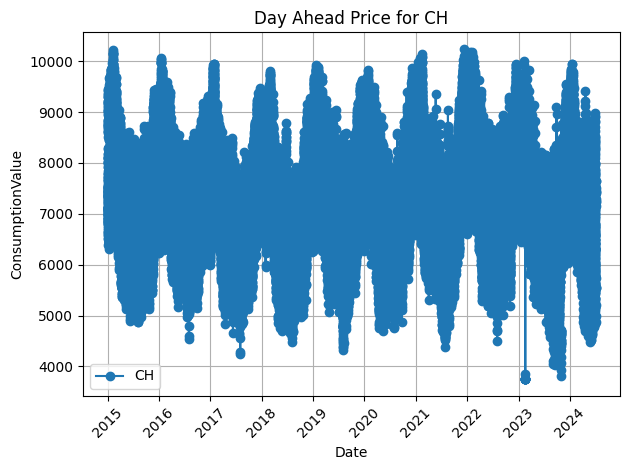

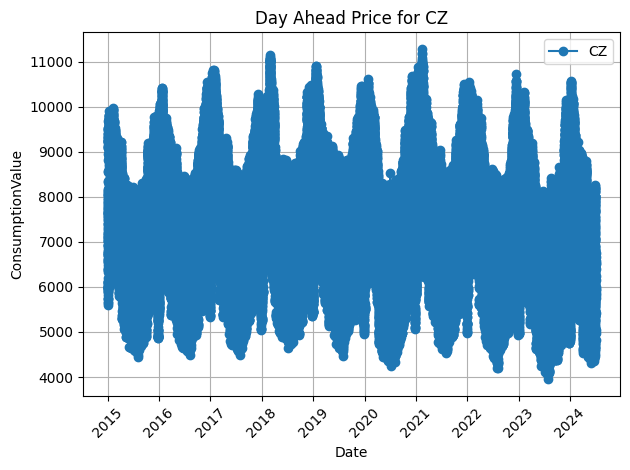

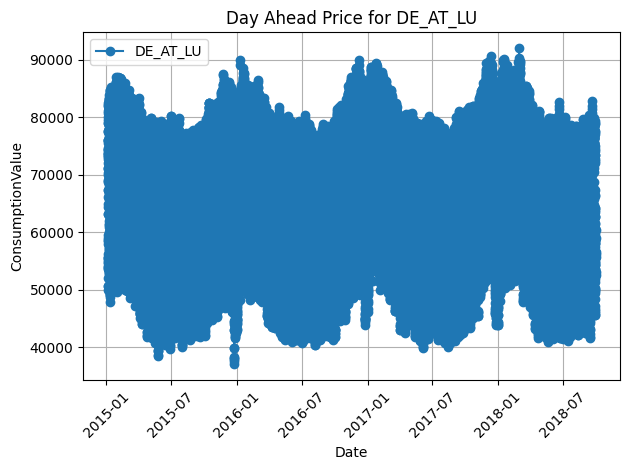

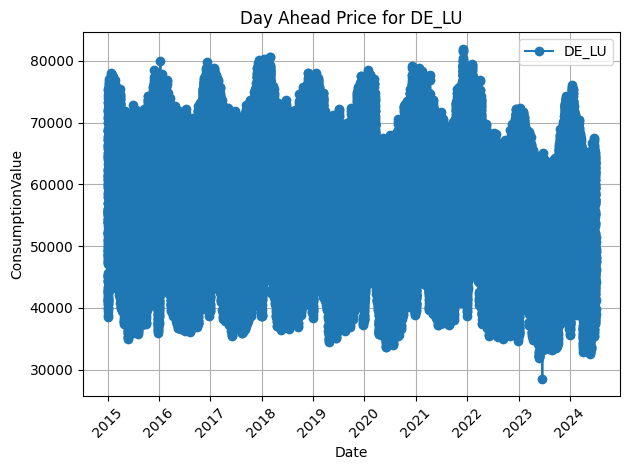

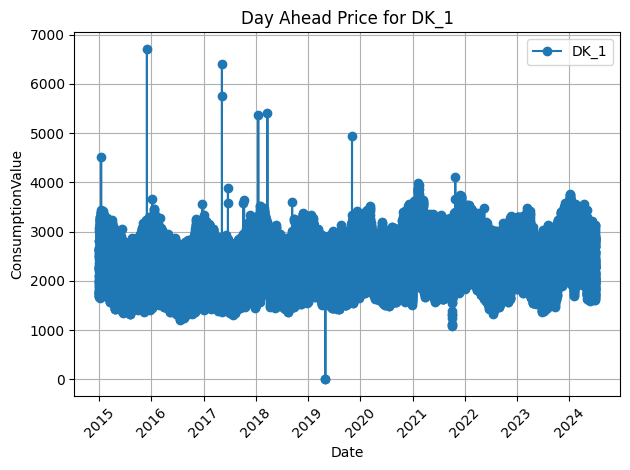

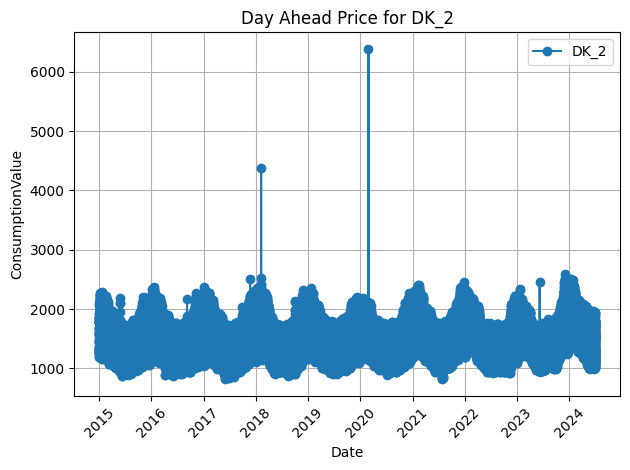

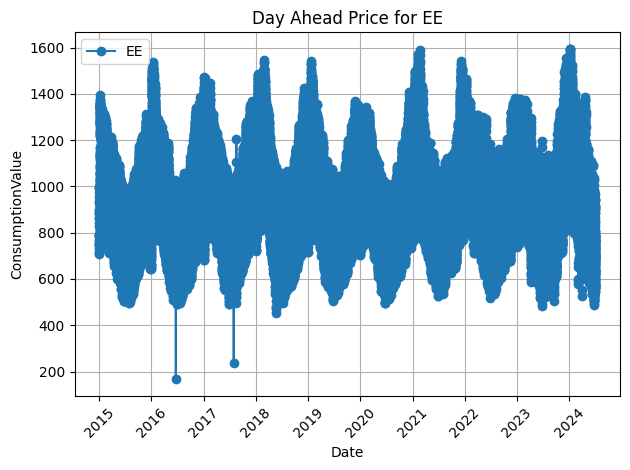

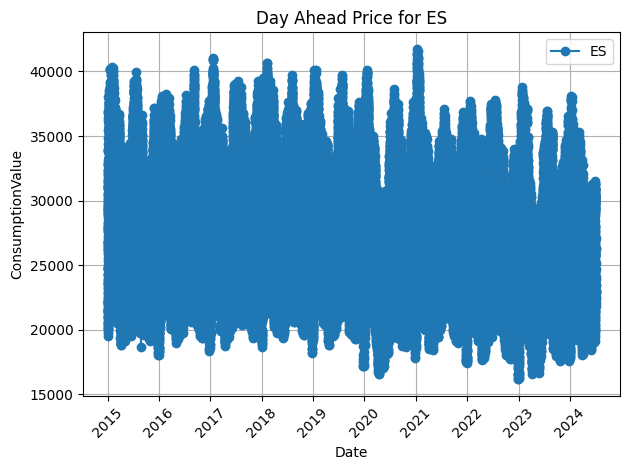

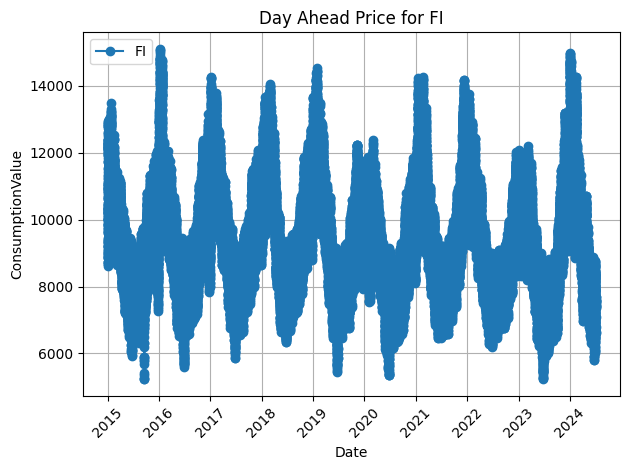

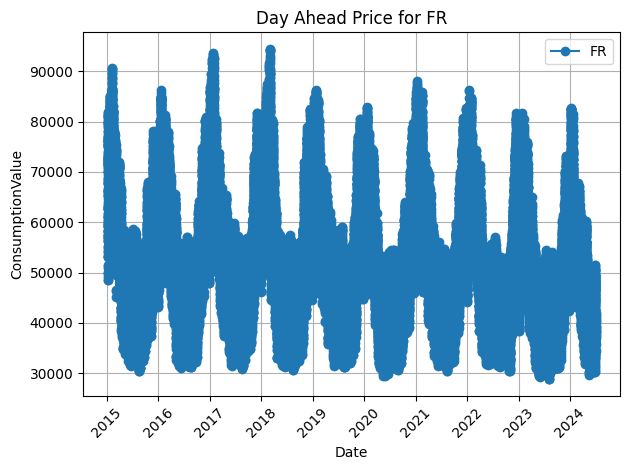

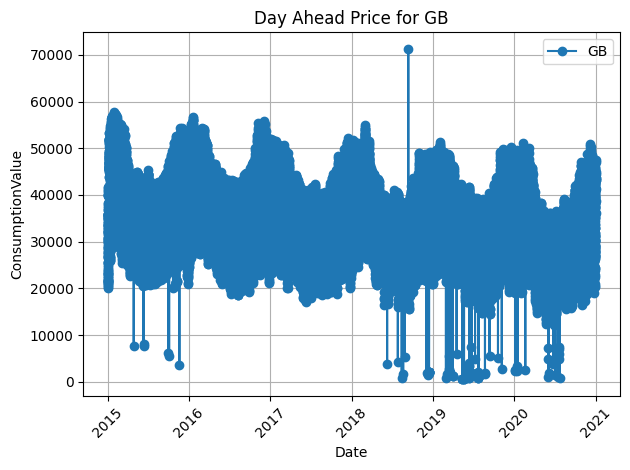

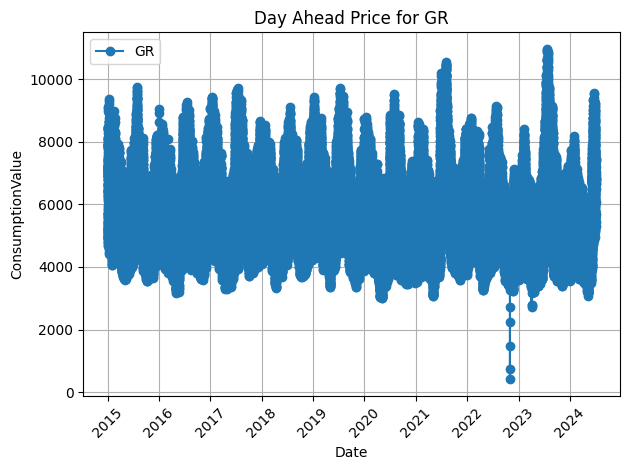

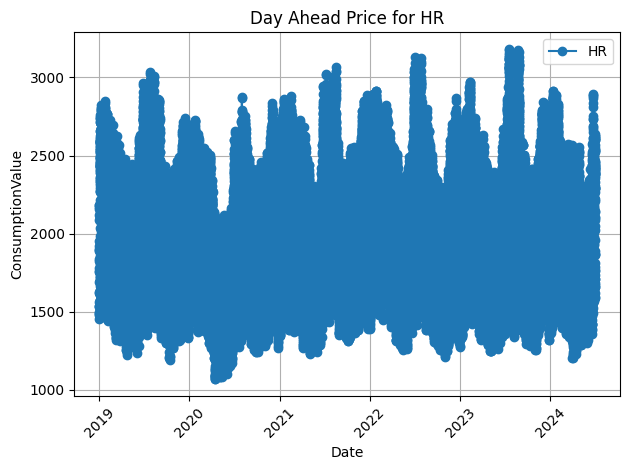

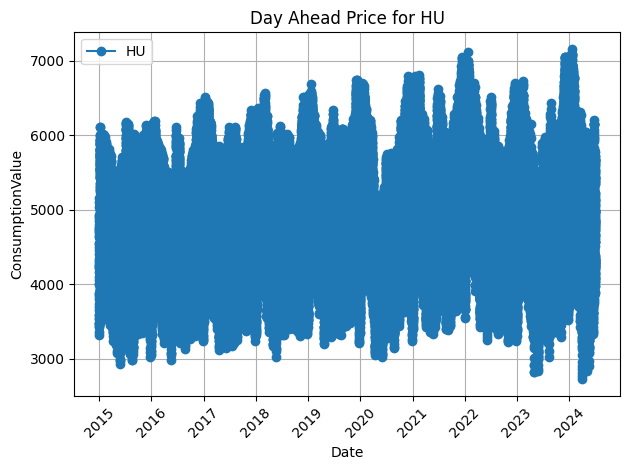

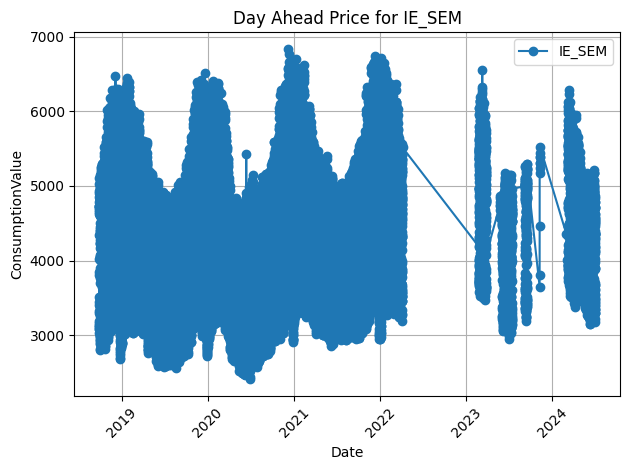

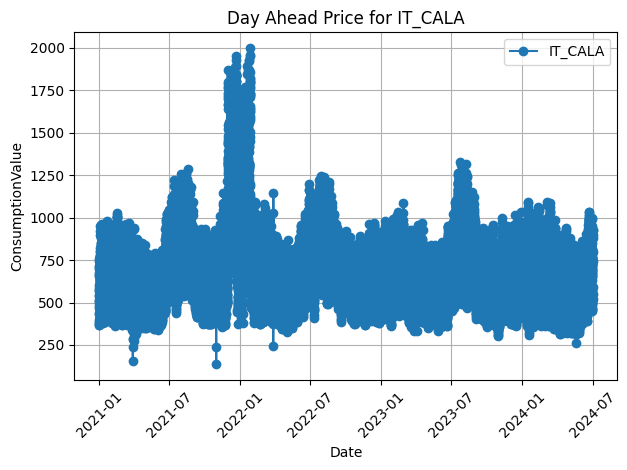

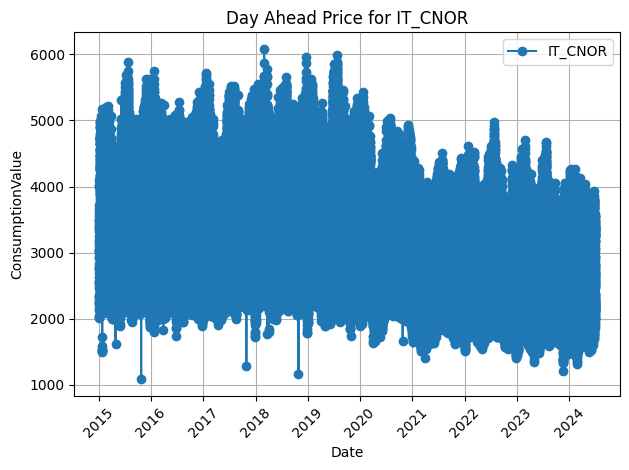

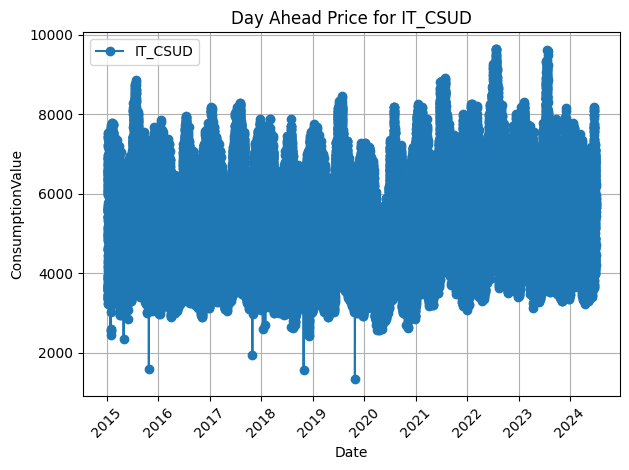

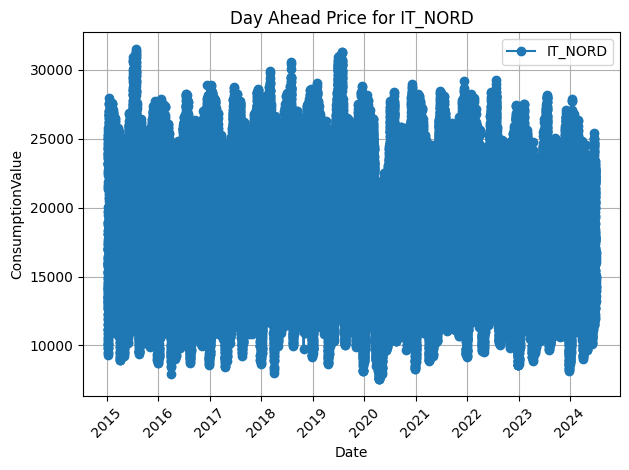

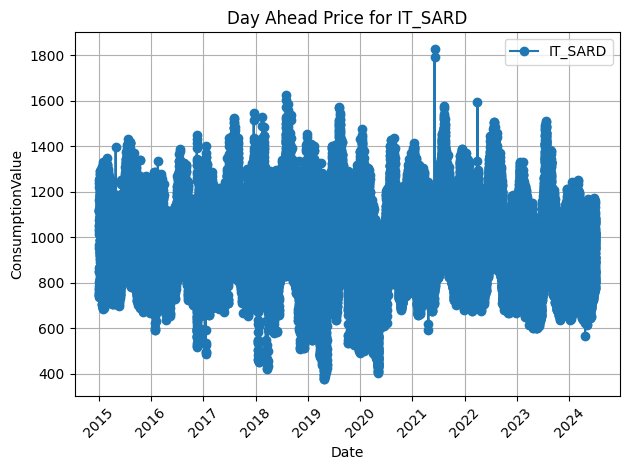

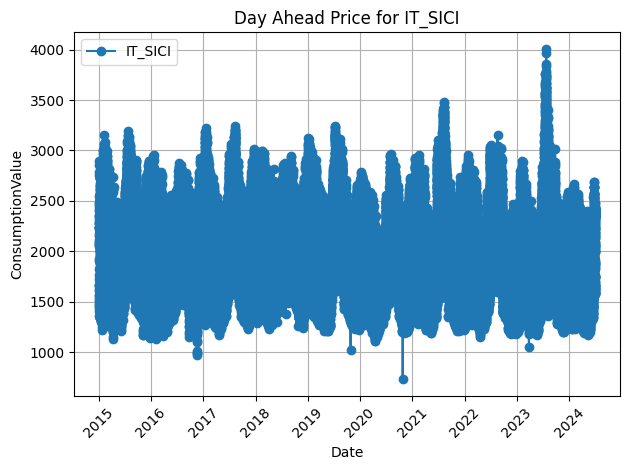

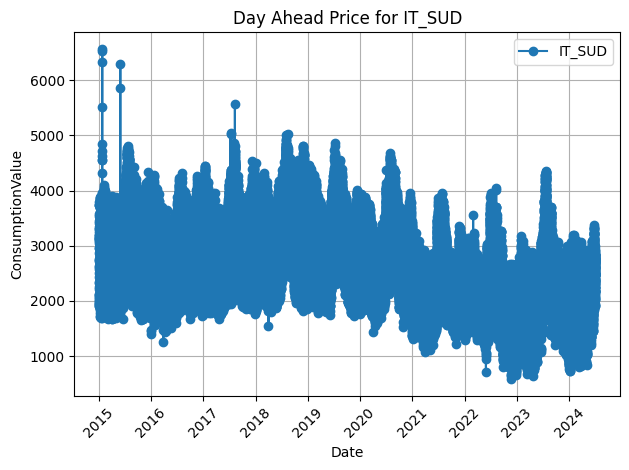

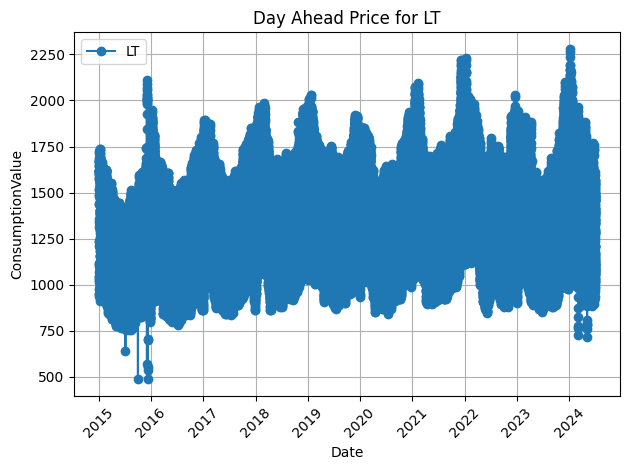

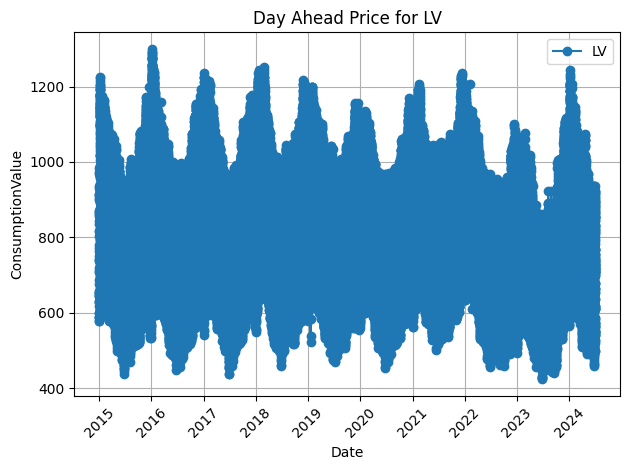

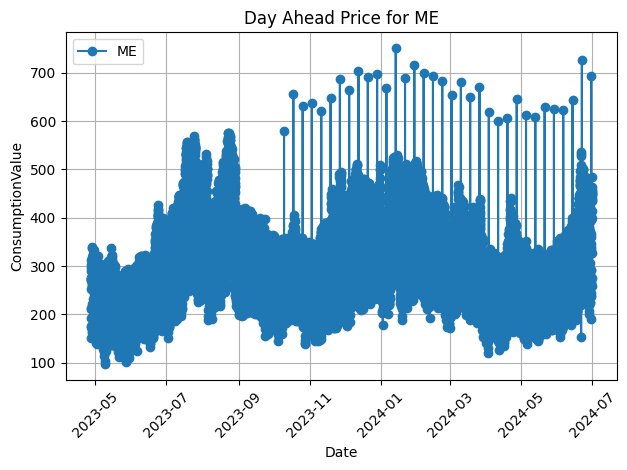

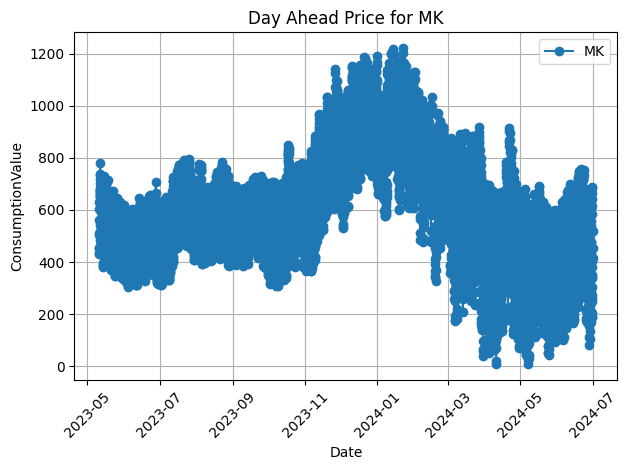

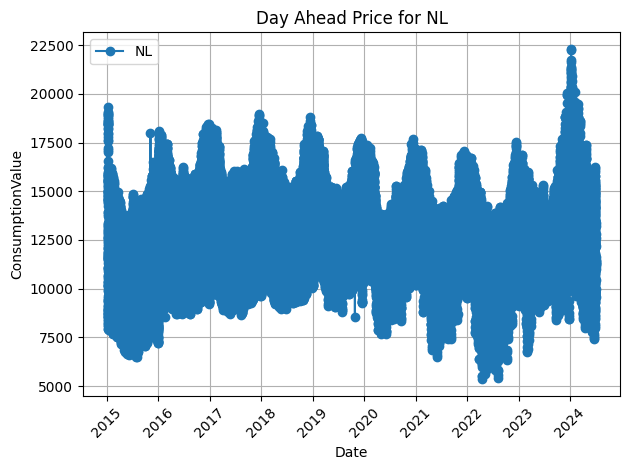

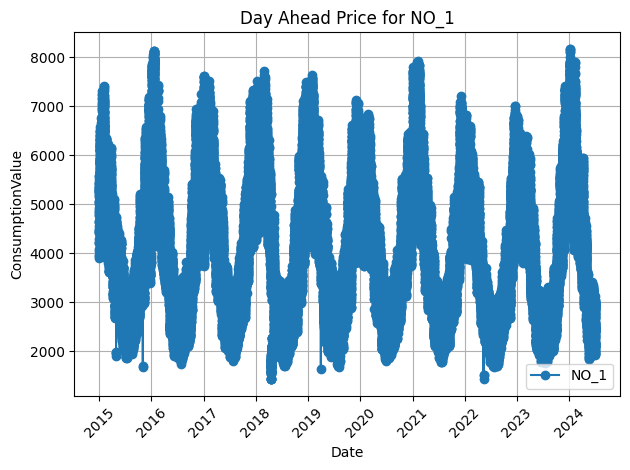

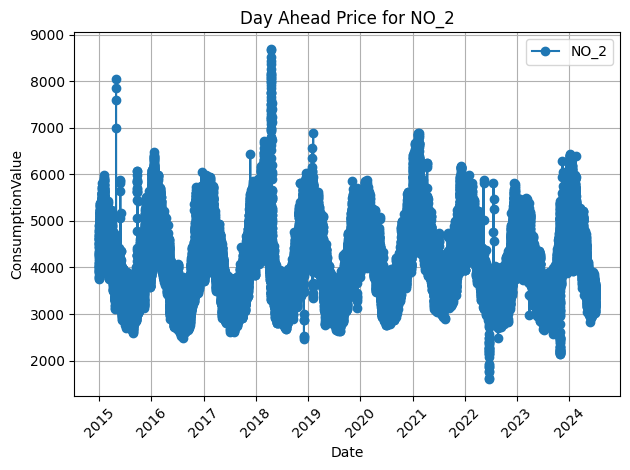

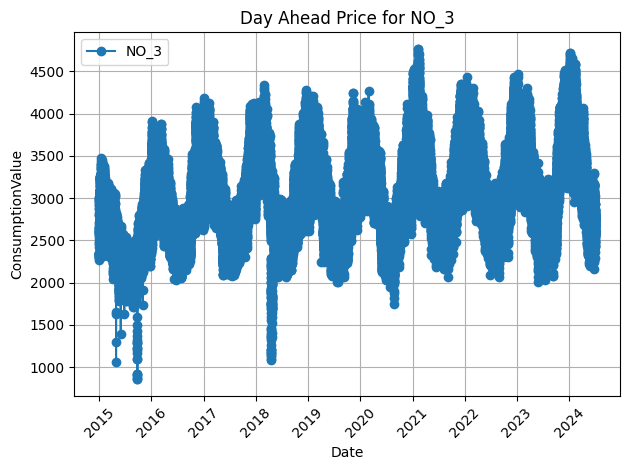

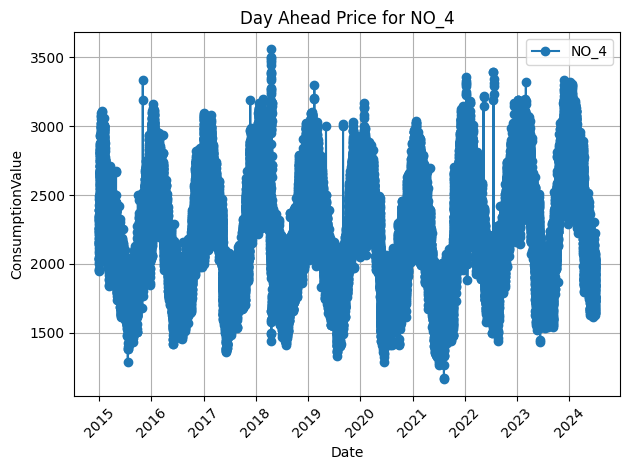

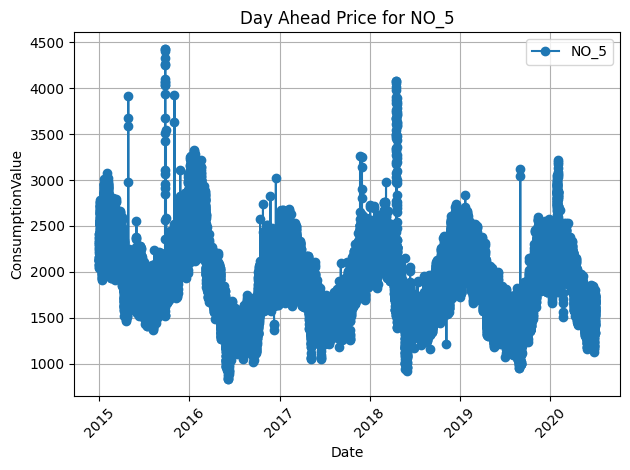

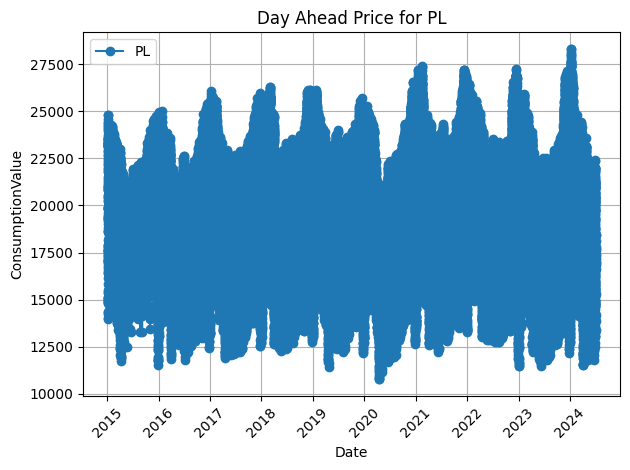

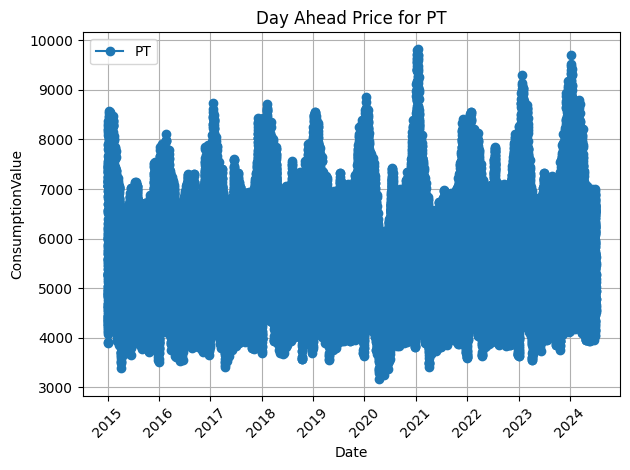

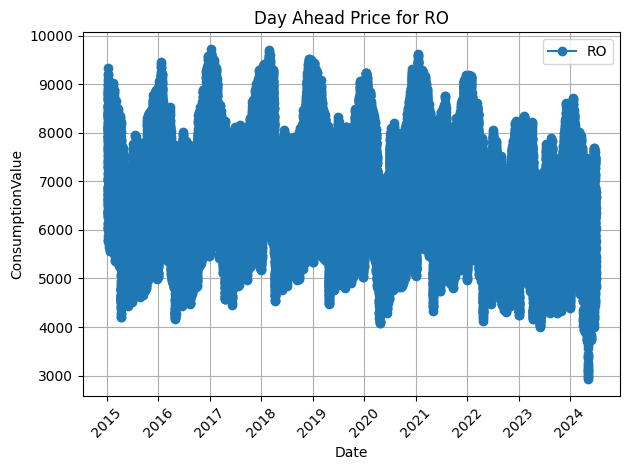

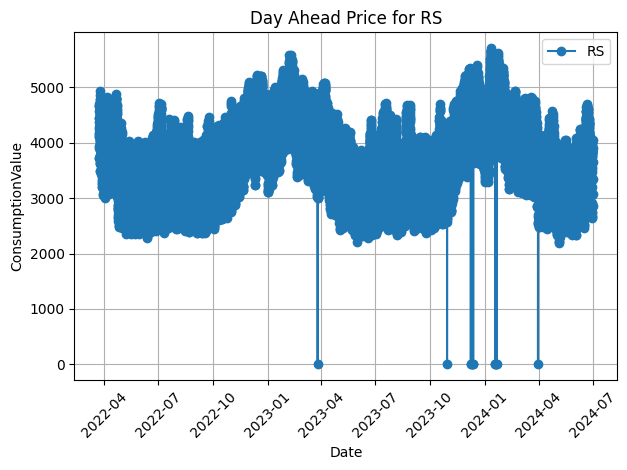

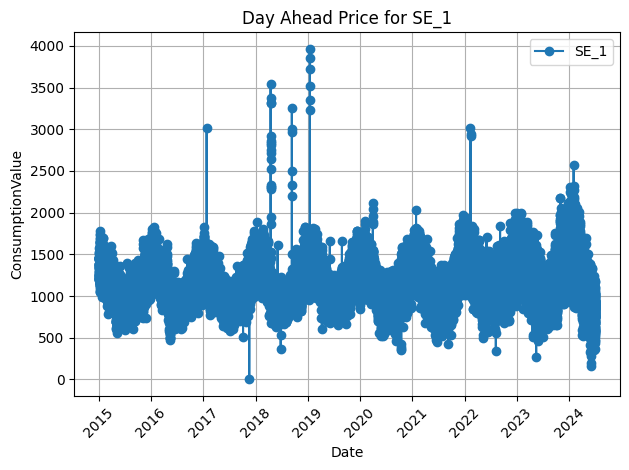

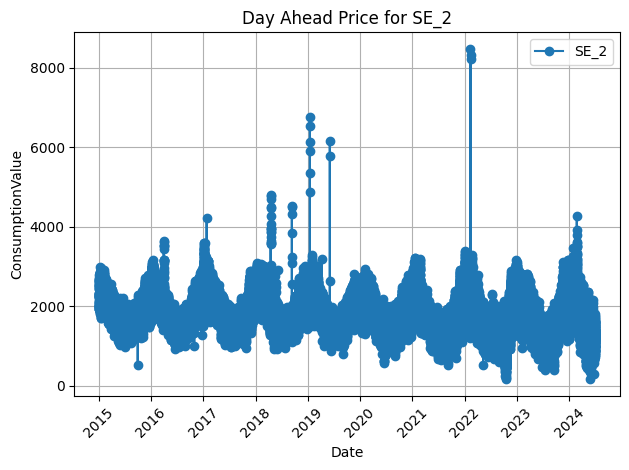

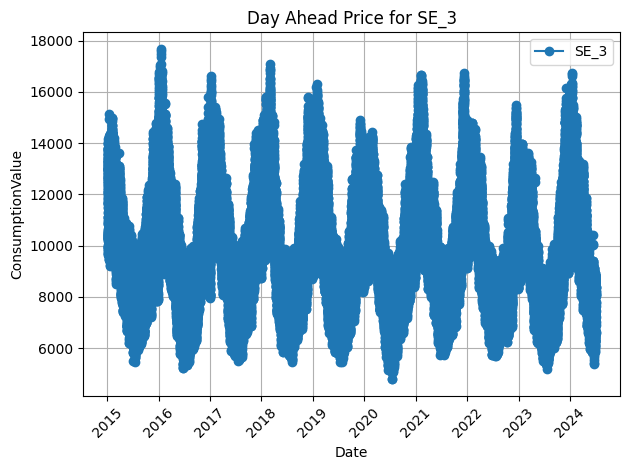

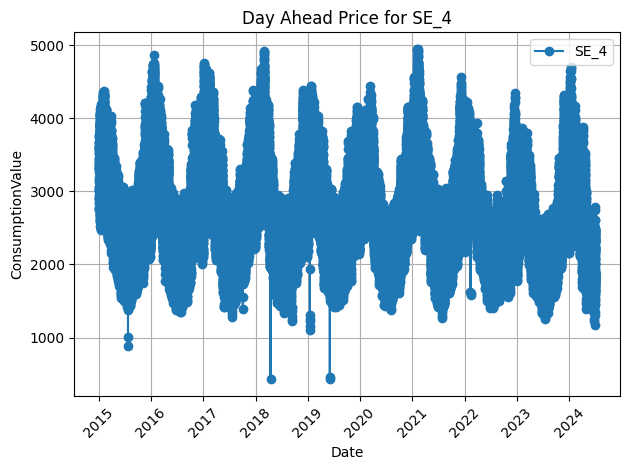

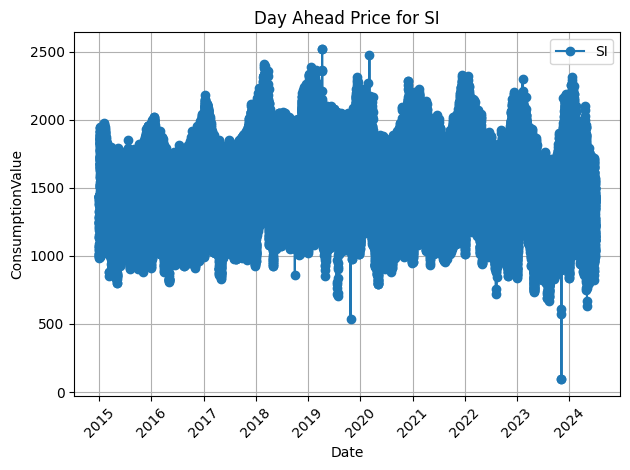

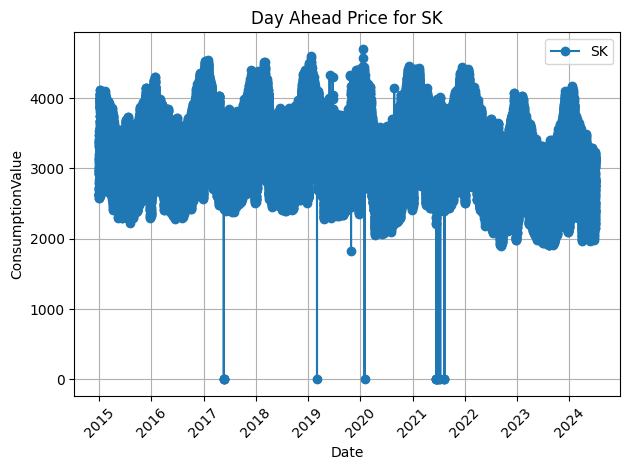

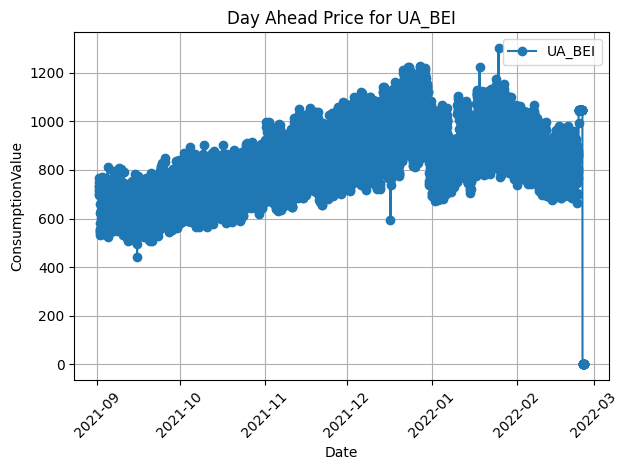

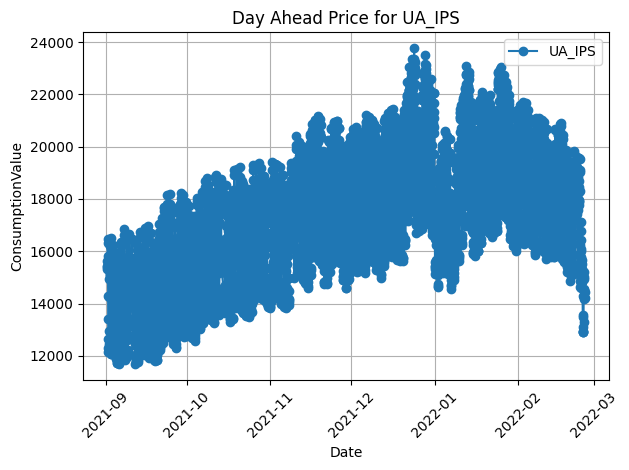

In [ ]:
grouped = filtered_data.groupby('PriceArea')

# Create separate plots for each PriceArea
for area, group in grouped:
    plt.figure()  # Create a new figure for each PriceArea
    plt.plot(group['Time'], group['ConsumptionValue'], marker='o', linestyle='-', label=f'{area}')
    plt.title(f'Day Ahead Price for {area}')
    plt.xlabel('Date')
    plt.ylabel('ConsumptionValue')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
filtered_data[filtered_data['PriceArea'] == 'GB']

,Unnamed: 0,Time,PriceArea,ConsumptionValue,DayAheadPriceEUR,WeatherWindSpeed,WeatherTemperature,Year,Month,Day,Hour,WeatherTemperature_F,Solar_MWh,Wind_Offshore,Wind_Onshore,ym,tempbin,tempbin2,block,YearMonthDay
13,2.0,2015-01-01 01:00:00,GB,27561.0,0.000000,13.457597,280.847748,2015.0,1.0,1.0,1.0,45.855946,0.0,234.0,1328.0,2015-01,3.0,2.102768,1.0,2015-01-01
30,29.0,2015-01-01 02:00:00,GB,25318.0,0.000000,13.526556,280.925049,2015.0,1.0,1.0,2.0,45.995088,0.0,240.0,1332.0,2015-01,3.0,2.115548,1.0,2015-01-01
58,43.0,2015-01-01 03:00:00,GB,23145.0,0.000000,13.358551,281.046570,2015.0,1.0,1.0,3.0,46.213826,0.0,228.0,1326.0,2015-01,3.0,2.135718,1.0,2015-01-01
76,66.0,2015-01-01 04:00:00,GB,21672.0,0.000000,13.099046,281.191406,2015.0,1.0,1.0,4.0,46.474531,0.0,230.0,1322.0,2015-01,3.0,2.159882,1.0,2015-01-01
98,85.0,2015-01-01 05:00:00,GB,21733.0,0.000000,12.884872,281.295105,2015.0,1.0,1.0,5.0,46.661189,0.0,224.0,1314.0,2015-01,3.0,2.177267,2.0,2015-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2038127,2018112.0,2020-12-31 18:00:00,GB,47119.0,84.791243,7.783380,276.469879,2020.0,12.0,31.0,18.0,37.975782,0.0,1761.0,3409.0,2020-12,2.0,1.442160,5.0,2020-12-31
2038175,2018143.0,2020-12-31 19:00:00,GB,44424.0,72.589867,7.758132,276.457916,2020.0,12.0,31.0,19.0,37.954249,1.0,1670.0,3404.0,2020-12,2.0,1.440525,5.0,2020-12-31
2038216,2018183.0,2020-12-31 20:00:00,GB,41349.0,71.816875,7.763143,276.420593,2020.0,12.0,31.0,20.0,37.887068,0.0,1556.0,3426.0,2020-12,2.0,1.435430,5.0,2020-12-31
2038254,2018219.0,2020-12-31 21:00:00,GB,38677.0,68.927075,7.829550,276.275909,2020.0,12.0,31.0,21.0,37.626637,0.0,1702.0,3304.0,2020-12,2.0,1.415764,6.0,2020-12-31


In [ ]:
filtered_data['PriceArea'].unique()

array(['CH', 'DE_LU', 'LV', 'SK', 'SI', 'PT', 'NO_3', 'NO_2', 'NO_1',
       'DK_2', 'NO_5', 'GR', 'NO_4', 'GB', 'FI', 'CZ', 'ES', 'DK_1', 'HU',
       'EE', 'AT', 'PL', 'LT', 'FR', 'IT_CSUD', 'IT_CNOR', 'SE_1',
       'IT_SUD', 'SE_2', 'SE_3', 'SE_4', 'IT_SICI', 'IT_NORD', 'BE',
       'IT_SARD', 'NL', 'DE_AT_LU', 'RO', 'BG', 'IE_SEM', 'HR', 'IT_CALA',
       'UA_BEI', 'UA_IPS', 'RS', 'ME', 'MK'], dtype=object)

In [ ]:
def calculate_correlations(filtered_data, filled_data_gas):
    correlation_results = {}

    # Ensure 'Trading_Day' is a datetime column
    filled_data_gas['Trading_Day'] = pd.to_datetime(filled_data_gas['Trading_Day'])

    # Loop through each unique PriceArea in filtered_data
    for price_area in filtered_data['PriceArea'].unique():
        # Step 1: Filter data for the current PriceArea
        filtered_ch = filtered_data[filtered_data['PriceArea'] == price_area]

        # Step 2: Select only the relevant columns
        filtered_ch = filtered_ch[['PriceArea', 'Time', 'DayAheadPriceEUR']]

        # Rename 'Time' to 'Trading_Day' to match the other DataFrame
        filtered_ch = filtered_ch.rename(columns={'Time': 'Trading_Day'})
        filtered_ch['Trading_Day'] = pd.to_datetime(filtered_ch['Trading_Day'])

        # Step 3: Merge filtered_ch with filled_data_gas on 'Trading_Day'
        merged_data = filled_data_gas.merge(filtered_ch, on='Trading_Day', how='inner', suffixes=('_gas', '_ch'))

        # Step 4: Check correlation by Price_Area in filled_data_gas
        for gas_price_area in filled_data_gas['Price_Area'].unique():
            subset = merged_data[merged_data['Price_Area'] == gas_price_area]
            if not subset.empty:
                correlation = subset['Last_Price'].corr(subset['DayAheadPriceEUR'])
                # Store the result with a clear label
                correlation_results[f"{price_area} vs {gas_price_area}"] = correlation

    # Return the results
    return correlation_results

correlation_results = calculate_correlations(filtered_data, filled_data_gas)

for key, value in correlation_results.items():
     print(f"Correlation {key}: {value:.2f}")

Correlation CH vs cegh: 0.96
Correlation CH vs cz: 0.96
Correlation CH vs etf: 0.96
Correlation CH vs nbp: 0.90
Correlation CH vs peg: 0.95
Correlation CH vs pvb: 0.82
Correlation CH vs the: 0.95
Correlation CH vs ttf: 0.96
Correlation CH vs ztp: 0.95
Correlation DE_LU vs cegh: 0.89
Correlation DE_LU vs cz: 0.90
Correlation DE_LU vs etf: 0.89
Correlation DE_LU vs nbp: 0.83
Correlation DE_LU vs peg: 0.87
Correlation DE_LU vs pvb: 0.72
Correlation DE_LU vs the: 0.89
Correlation DE_LU vs ttf: 0.89
Correlation DE_LU vs ztp: 0.87
Correlation LV vs cegh: 0.80
Correlation LV vs cz: 0.79
Correlation LV vs etf: 0.80
Correlation LV vs nbp: 0.71
Correlation LV vs peg: 0.76
Correlation LV vs pvb: 0.65
Correlation LV vs the: 0.78
Correlation LV vs ttf: 0.80
Correlation LV vs ztp: 0.77
Correlation SK vs cegh: 0.91
Correlation SK vs cz: 0.92
Correlation SK vs etf: 0.91
Correlation SK vs nbp: 0.85
Correlation SK vs peg: 0.89
Correlation SK vs pvb: 0.76
Correlation SK vs the: 0.90
Correlation SK vs ttf

In [ ]:
filtered_data['PriceArea'].unique()

array(['CH', 'DE_LU', 'LV', 'SK', 'SI', 'PT', 'NO_3', 'NO_2', 'NO_1',
       'DK_2', 'NO_5', 'GR', 'NO_4', 'GB', 'FI', 'CZ', 'ES', 'DK_1', 'HU',
       'EE', 'AT', 'PL', 'LT', 'FR', 'IT_CSUD', 'IT_CNOR', 'SE_1',
       'IT_SUD', 'SE_2', 'SE_3', 'SE_4', 'IT_SICI', 'IT_NORD', 'BE',
       'IT_SARD', 'NL', 'DE_AT_LU', 'RO', 'BG', 'IE_SEM', 'HR', 'IT_CALA',
       'UA_BEI', 'UA_IPS', 'RS', 'ME', 'MK'], dtype=object)

In [ ]:
price_area_mapping = {
    'CH': 'cegh', 'CZ': 'cz', 'DK_1': 'etf', 'DK_2': 'etf', 'EE': 'etf', 'ES': 'pvb', 'FI': 'ttf',
    'GB': 'nbp', 'GR': 'cegh', 'HU': 'cegh', 'LV': 'etf', 'NO_1': 'etf', 'NO_2': 'etf',
    'NO_3': 'etf', 'NO_4': 'etf', 'NO_5': 'etf', 'PT': 'cz', 'SI': 'cegh', 'SK': 'cz',
    'PL': 'pvb', 'LT': 'etf', 'BE': 'ztp', 'DE_AT_LU': 'the', 'FR': 'peg', 'IT_CNOR': 'cegh',
    'IT_CSUD': 'cegh', 'IT_NORD': 'cegh', 'IT_SARD': 'cegh', 'IT_SICI': 'cegh', 'IT_SUD': 'cegh',
    'NL': 'ttf', 'SE_1': 'etf', 'SE_2': 'etf', 'SE_3': 'etf', 'SE_4': 'etf', 'RO': 'cz',
    'BG': 'cz', 'IE_SEM': 'nbp', 'AT': 'cegh', 'DE_LU': 'the', 'HR': 'cegh', 'IT_CALA': 'cegh',
    'UA_BEI': 'the', 'UA_IPS': 'the', 'RS': 'cegh', 'ME': 'cegh', 'MK': 'cegh'
}


filtered_data['Price_Area'] = filtered_data['PriceArea'].map(price_area_mapping)
filtered_data['YearMonthDay'] = pd.to_datetime(filtered_data['YearMonthDay'])

merged_data = filtered_data.merge(
    filled_data_gas,
    left_on=['YearMonthDay', 'Price_Area'],
    right_on=['Trading_Day', 'Price_Area'],
    how='left'
)

result = merged_data.drop(columns=['Trading_Day'])

print(result.head(10))

   Unnamed: 0                Time PriceArea  ConsumptionValue  \
0         0.0 2015-01-01 01:00:00        CH            7654.0   
1         NaN 2015-01-01 01:00:00     DE_LU           44237.0   
2        19.0 2015-01-01 01:00:00        LV             645.0   
3        17.0 2015-01-01 01:00:00        SK            2728.0   
4        16.0 2015-01-01 01:00:00        SI            1045.0   
5        15.0 2015-01-01 01:00:00        PT            5124.0   
6        13.0 2015-01-01 01:00:00      NO_3            2307.0   
7        12.0 2015-01-01 01:00:00      NO_2            4039.0   
8        11.0 2015-01-01 01:00:00      NO_1            4552.0   
9        10.0 2015-01-01 01:00:00      DK_2            1305.0   

   DayAheadPriceEUR  WeatherWindSpeed  WeatherTemperature    Year  Month  Day  \
0             38.08          3.647062          267.706482  2015.0    1.0  1.0   
1               NaN          4.465744          272.602615  2015.0    1.0  1.0   
2             29.56          7.677394    

In [ ]:
def read_csv_with_datetime_index(file_path):
    # Read the CSV and parse the "Date" column as datetime
    df = pd.read_csv(file_path)
    df["Date"] = pd.to_datetime(df["Date"])

    # Set the "Date" column as index
    df.set_index("Date", inplace=True)

    # Convert "Price" to numeric and coerce errors
    df["Price"] = pd.to_numeric(df["Price"], errors="coerce")

    # Fill missing values in "Price" using forward-fill
    df["Price"].fillna(method='ffill', inplace=True)

    # Create a daily index to fill missing dates
    daily_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
    df = df.reindex(daily_index)

    # After reindexing, apply forward-fill again and backward-fill for remaining NaNs
    df["Price"].fillna(method='ffill', inplace=True) # Fill remaining NaNs at the start

    # Filter the data by the given date range
    start_date = pd.Timestamp('2014-12-01')
    end_date = pd.Timestamp('2024-07-01')

    # Filter using the index since "Date" is now the index
    filtered_df = df[(df.index >= start_date) & (df.index <= end_date)]

    # Return the "Price" series for the filtered date range
    price_series = filtered_df["Price"]
    price_series = price_series.resample('H').ffill()
    price_series = price_series.reset_index()
    price_series["Time"] = price_series["index"]
    price_series.drop(columns=['index'], inplace=True)

    return price_series
#%%
filtered_data = result.copy()
filtered_data = filtered_data.rename(columns={'Last_Price': 'Price_gas'})
file_path = ("European_Union_Allowance (EUA).csv")
file_path_eua = read_csv_with_datetime_index(file_path)
file_path_eua['Price_EUA'] = file_path_eua['Price']
file_path_eua.drop(columns=['Price'], inplace=True)
file_path = ("Coal(API2)CIF_AR (ARGUS-McCloskey).csv")
file_path_coal = read_csv_with_datetime_index(file_path)
file_path_coal['Price_coal'] = file_path_coal['Price']
file_path_coal.drop(columns=['Price'], inplace=True)
filtered_data = pd.merge(filtered_data, file_path_coal, on="Time", how="left")
filtered_data = pd.merge(filtered_data, file_path_eua, on="Time", how="left")
#%%
filtered_data_wind_gen_na = filtered_data.dropna(subset=['ConsumptionValue', 'WeatherTemperature_F', 'Solar_MWh', 'Wind_Onshore', 'DayAheadPriceEUR', 'Price_gas', 'Price_coal', 'Price_EUA']).reset_index(drop=True)
filtered_data_wind_gen_na['Wind_Offshore'] = filtered_data_wind_gen_na['Wind_Offshore'].fillna(0)
filtered_data_wind_gen_na.head()

,Unnamed: 0,Time,PriceArea,ConsumptionValue,DayAheadPriceEUR,WeatherWindSpeed,WeatherTemperature,Year,Month,Day,...,Wind_Onshore,ym,tempbin,tempbin2,block,YearMonthDay,Price_Area,Price_gas,Price_coal,Price_EUA
0,0.0,2015-01-01 01:00:00,CH,7654.0,38.08,3.647062,267.706482,2015.0,1.0,1.0,...,14.0,2015-01,1.0,0.492914,1.0,2015-01-01,cegh,20.65,66.7,7.34
1,17.0,2015-01-01 01:00:00,SK,2728.0,22.06,3.991796,265.239655,2015.0,1.0,1.0,...,0.0,2015-01,1.0,0.315467,1.0,2015-01-01,cz,20.65,66.7,7.34
2,16.0,2015-01-01 01:00:00,SI,1045.0,22.20,4.172168,265.189819,2015.0,1.0,1.0,...,1.0,2015-01,1.0,0.312288,1.0,2015-01-01,cegh,20.65,66.7,7.34
3,15.0,2015-01-01 01:00:00,PT,5124.0,47.33,6.417383,279.455658,2015.0,1.0,1.0,...,551.0,2015-01,3.0,1.879238,1.0,2015-01-01,cz,20.65,66.7,7.34
4,10.0,2015-01-01 01:00:00,DK_2,1305.0,16.04,10.561893,276.635590,2015.0,1.0,1.0,...,248.0,2015-01,2.0,1.464904,1.0,2015-01-01,etf,20.65,66.7,7.34


In [ ]:
filtered_data_wind_gen_na.drop(filtered_data_wind_gen_na[filtered_data_wind_gen_na['PriceArea'] == 'GB'].index, inplace = True)

In [ ]:
filtered_data_wind_gen_na

,Unnamed: 0,Time,PriceArea,ConsumptionValue,DayAheadPriceEUR,WeatherWindSpeed,WeatherTemperature,Year,Month,Day,...,Wind_Onshore,ym,tempbin,tempbin2,block,YearMonthDay,Price_Area,Price_gas,Price_coal,Price_EUA
0,0.0,2015-01-01 01:00:00,CH,7654.0,38.08,3.647062,267.706482,2015.0,1.0,1.0,...,14.0,2015-01,1.0,0.492914,1.0,2015-01-01,cegh,20.650,66.7,7.34
1,17.0,2015-01-01 01:00:00,SK,2728.0,22.06,3.991796,265.239655,2015.0,1.0,1.0,...,0.0,2015-01,1.0,0.315467,1.0,2015-01-01,cz,20.650,66.7,7.34
2,16.0,2015-01-01 01:00:00,SI,1045.0,22.20,4.172168,265.189819,2015.0,1.0,1.0,...,1.0,2015-01,1.0,0.312288,1.0,2015-01-01,cegh,20.650,66.7,7.34
3,15.0,2015-01-01 01:00:00,PT,5124.0,47.33,6.417383,279.455658,2015.0,1.0,1.0,...,551.0,2015-01,3.0,1.879238,1.0,2015-01-01,cz,20.650,66.7,7.34
4,10.0,2015-01-01 01:00:00,DK_2,1305.0,16.04,10.561893,276.635590,2015.0,1.0,1.0,...,248.0,2015-01,2.0,1.464904,1.0,2015-01-01,etf,20.650,66.7,7.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2331237,3242770.0,2024-07-01 00:00:00,LV,541.0,81.35,8.096815,292.413696,2024.0,7.0,1.0,...,56.0,2024-07,5.0,4.445509,6.0,2024-07-01,etf,35.225,103.7,68.33
2331238,3242773.0,2024-07-01 00:00:00,EE,560.0,81.35,9.700132,290.992065,2024.0,7.0,1.0,...,227.0,2024-07,5.0,4.110825,6.0,2024-07-01,etf,35.225,103.7,68.33
2331239,3242774.0,2024-07-01 00:00:00,NL,9551.0,78.19,6.221703,287.067200,2024.0,7.0,1.0,...,564.0,2024-07,4.0,3.254812,6.0,2024-07-01,ttf,32.775,103.7,68.33
2331240,3242750.0,2024-07-01 00:00:00,FR,34397.0,52.95,5.007311,288.667023,2024.0,7.0,1.0,...,2290.0,2024-07,4.0,3.591682,6.0,2024-07-01,peg,32.625,103.7,68.33


In [ ]:
from datetime import date

# Updated PRICE_AREA_TO_COUNTRY mapping
PRICE_AREA_TO_COUNTRY = {
    # Denmark
    'DK_1': ('DK', None),
    'DK_2': ('DK', None),
    # Norway
    'NO_1': ('NO', None),
    'NO_2': ('NO', None),
    'NO_3': ('NO', None),
    'NO_4': ('NO', None),
    'NO_5': ('NO', None),
    # Germany
    'DE_AT_LU': ('DE', 'BY'),  # Bavaria
    'DE_LU': ('DE', 'BE'),  # Berlin
    # Ukraine
    'UA_BEI': ('UA', None),
    'UA_IPS': ('UA', None),
    # Sweden
    'SE_1': ('SE', None),
    'SE_2': ('SE', None),
    'SE_3': ('SE', None),
    'SE_4': ('SE', None),
    # Italy
    'IT_CNOR': ('IT', 'RM'),  # Rome
    'IT_CSUD': ('IT', 'NA'),  # Naples
    'IT_NORD': ('IT', None),
    'IT_SARD': ('IT', None),
    'IT_SICI': ('IT', None),
    'IT_SUD': ('IT', None),
    'IT_CALA': ('IT', None),
    # United Kingdom
    'GB': ('GB', 'ENG'),  # England
    # Portugal
    'PT': ('PT', None),
    # Netherlands
    'NL': ('NL', None),
    # Czech Republic
    'CZ': ('CZ', None),
    # Romania
    'RO': ('RO', None),
    # Spain
    'ES': ('ES', None),
    # Finland
    'FI': ('FI', None),
    # Croatia
    'HR': ('HR', None),
    # Poland
    'PL': ('PL', None),
    # Ireland
    'IE_SEM': ('IE', None),
    # Slovakia
    'SK': ('SK', None),
    # Estonia
    'EE': ('EE', None),
    # Switzerland
    'CH': ('CH', None),  # Default to Zurich for Switzerland
    # Bulgaria
    'BG': ('BG', None),
    # Austria
    'AT': ('AT', None),
    # Slovenia
    'SI': ('SI', None),
    # France
    'FR': ('FR', None),
    # Hungary
    'HU': ('HU', None),
    # Latvia
    'LV': ('LV', None),
    # Greece
    'GR': ('GR', None),
    # Lithuania
    'LT': ('LT', None),
    # Serbia
    'RS': ('RS', None),
    # Belgium
    'BE': ('BE', None),
    # Montenegro
    'ME': ('ME', None),
    # North Macedonia
    'MK': ('MK', None),
}

def add_holidays(filtered_data):
    # Ensure YearMonthDay is a datetime.date object
    filtered_data['YearMonthDay'] = pd.to_datetime(filtered_data['YearMonthDay']).dt.date

    # Initialize the IsHoliday column
    filtered_data['IsHoliday'] = 0

    # Iterate over unique PriceArea values
    unique_areas = filtered_data['PriceArea'].unique()
    for area in unique_areas:
        # Map PriceArea to a broader country code (with optional subdivision)
        mapping = PRICE_AREA_TO_COUNTRY.get(area, (None, None))
        country, subdiv = mapping

        try:
            # Fetch holidays for the country and subdivision
            holidays_obj = holidays.country_holidays(country, subdiv=subdiv) if subdiv else holidays.country_holidays(country)

            # Debugging: Print first few holidays
            print(f"Holidays for {country} (subdiv={subdiv}): {list(holidays_obj.keys())[:5]}")

        except Exception as e:
            print(f"Skipped unsupported country or area: {country} (subdiv={subdiv}). Error: {e}")
            continue

        # Set IsHoliday to 1 for matching rows
        filtered_data.loc[
            (filtered_data['PriceArea'] == area) &
            (filtered_data['YearMonthDay'].apply(lambda x: x in holidays_obj)),
            'IsHoliday'
        ] = 1

    return filtered_data

filtered_data_with_holidays = add_holidays(filtered_data_wind_gen_na)
filtered_data_with_holidays


Holidays for CH (subdiv=None): []
Holidays for SK (subdiv=None): []
Holidays for SI (subdiv=None): []
Holidays for PT (subdiv=None): []
Holidays for DK (subdiv=None): []
Holidays for GR (subdiv=None): []
Holidays for CZ (subdiv=None): []
Holidays for ES (subdiv=None): []
Holidays for DK (subdiv=None): []
Holidays for EE (subdiv=None): []
Holidays for AT (subdiv=None): []
Holidays for LT (subdiv=None): []
Holidays for DE (subdiv=BE): []
Holidays for FR (subdiv=None): []
Holidays for IT (subdiv=NA): []
Holidays for IT (subdiv=RM): []
Holidays for IT (subdiv=None): []
Holidays for IT (subdiv=None): []
Holidays for IT (subdiv=None): []
Holidays for BE (subdiv=None): []
Holidays for IT (subdiv=None): []
Holidays for NL (subdiv=None): []
Holidays for DE (subdiv=BY): []
Holidays for RO (subdiv=None): []
Holidays for BG (subdiv=None): []
Holidays for HR (subdiv=None): []
Holidays for HU (subdiv=None): []
Holidays for PL (subdiv=None): []
Holidays for IT (subdiv=None): []
Holidays for UA (subdi

,Unnamed: 0,Time,PriceArea,ConsumptionValue,DayAheadPriceEUR,WeatherWindSpeed,WeatherTemperature,Year,Month,Day,...,ym,tempbin,tempbin2,block,YearMonthDay,Price_Area,Price_gas,Price_coal,Price_EUA,IsHoliday
0,0.0,2015-01-01 01:00:00,CH,7654.0,38.08,3.647062,267.706482,2015.0,1.0,1.0,...,2015-01,1.0,0.492914,1.0,2015-01-01,cegh,20.650,66.7,7.34,1
1,17.0,2015-01-01 01:00:00,SK,2728.0,22.06,3.991796,265.239655,2015.0,1.0,1.0,...,2015-01,1.0,0.315467,1.0,2015-01-01,cz,20.650,66.7,7.34,1
2,16.0,2015-01-01 01:00:00,SI,1045.0,22.20,4.172168,265.189819,2015.0,1.0,1.0,...,2015-01,1.0,0.312288,1.0,2015-01-01,cegh,20.650,66.7,7.34,1
3,15.0,2015-01-01 01:00:00,PT,5124.0,47.33,6.417383,279.455658,2015.0,1.0,1.0,...,2015-01,3.0,1.879238,1.0,2015-01-01,cz,20.650,66.7,7.34,1
4,10.0,2015-01-01 01:00:00,DK_2,1305.0,16.04,10.561893,276.635590,2015.0,1.0,1.0,...,2015-01,2.0,1.464904,1.0,2015-01-01,etf,20.650,66.7,7.34,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2331237,3242770.0,2024-07-01 00:00:00,LV,541.0,81.35,8.096815,292.413696,2024.0,7.0,1.0,...,2024-07,5.0,4.445509,6.0,2024-07-01,etf,35.225,103.7,68.33,0
2331238,3242773.0,2024-07-01 00:00:00,EE,560.0,81.35,9.700132,290.992065,2024.0,7.0,1.0,...,2024-07,5.0,4.110825,6.0,2024-07-01,etf,35.225,103.7,68.33,0
2331239,3242774.0,2024-07-01 00:00:00,NL,9551.0,78.19,6.221703,287.067200,2024.0,7.0,1.0,...,2024-07,4.0,3.254812,6.0,2024-07-01,ttf,32.775,103.7,68.33,0
2331240,3242750.0,2024-07-01 00:00:00,FR,34397.0,52.95,5.007311,288.667023,2024.0,7.0,1.0,...,2024-07,4.0,3.591682,6.0,2024-07-01,peg,32.625,103.7,68.33,0


In [ ]:
filtered_data_with_holidays[filtered_data_with_holidays['PriceArea'] == 'CH'].head(50)

,Unnamed: 0,Time,PriceArea,ConsumptionValue,DayAheadPriceEUR,WeatherWindSpeed,WeatherTemperature,Year,Month,Day,...,ym,tempbin,tempbin2,block,YearMonthDay,Price_Area,Price_gas,Price_coal,Price_EUA,IsHoliday
0,0.0,2015-01-01 01:00:00,CH,7654.0,38.08,3.647062,267.706482,2015.0,1.0,1.0,...,2015-01,1.0,0.492914,1.0,2015-01-01,cegh,20.65,66.70,7.34,1
20,26.0,2015-01-01 02:00:00,CH,7397.0,35.47,3.526751,268.095337,2015.0,1.0,1.0,...,2015-01,1.0,0.524484,1.0,2015-01-01,cegh,20.65,66.70,7.34,1
27,49.0,2015-01-01 03:00:00,CH,7340.0,30.83,3.461258,268.477448,2015.0,1.0,1.0,...,2015-01,1.0,0.556460,1.0,2015-01-01,cegh,20.65,66.70,7.34,1
46,71.0,2015-01-01 04:00:00,CH,7015.0,28.26,3.366277,268.812744,2015.0,1.0,1.0,...,2015-01,1.0,0.585298,1.0,2015-01-01,cegh,20.65,66.70,7.34,1
57,92.0,2015-01-01 05:00:00,CH,7059.0,25.36,3.215529,269.108734,2015.0,1.0,1.0,...,2015-01,1.0,0.611361,2.0,2015-01-01,cegh,20.65,66.70,7.34,1
62,115.0,2015-01-01 06:00:00,CH,6857.0,26.93,3.091212,269.372620,2015.0,1.0,1.0,...,2015-01,1.0,0.635076,2.0,2015-01-01,cegh,20.65,66.70,7.34,1
72,143.0,2015-01-01 07:00:00,CH,6636.0,24.95,3.020055,269.661194,2015.0,1.0,1.0,...,2015-01,1.0,0.661526,2.0,2015-01-01,cegh,20.65,66.70,7.34,1
86,158.0,2015-01-01 08:00:00,CH,6583.0,26.71,2.801819,270.121613,2015.0,1.0,1.0,...,2015-01,1.0,0.704844,2.0,2015-01-01,cegh,20.65,66.70,7.34,1
95,183.0,2015-01-01 09:00:00,CH,6838.0,30.04,2.417321,270.715271,2015.0,1.0,1.0,...,2015-01,1.0,0.762726,3.0,2015-01-01,cegh,20.65,66.70,7.34,1
115,188.0,2015-01-01 10:00:00,CH,6865.0,31.77,2.008936,271.465851,2015.0,1.0,1.0,...,2015-01,1.0,0.839176,3.0,2015-01-01,cegh,20.65,66.70,7.34,1


In [ ]:
print(filtered_data['YearMonthDay'].head())
print(type(filtered_data['YearMonthDay'].iloc[0]))

0   2015-01-01
1   2015-01-01
2   2015-01-01
3   2015-01-01
4   2015-01-01
Name: YearMonthDay, dtype: datetime64[ns]
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [ ]:
filtered_data_with_holidays.to_csv("filtered_data_with_holidays.csv")